# Empirical Mode Decomposition (EMD) for EEG Denoising Under tES

We provide in this notebook a simple example of applying Empirical Mode Decomposition (EMD) + Mutual Information to EEG denoising under tES (Transcranial Electrical Stimulation).

For the EMD decomposition we use the following `Python` library: [PyEMD GitHub Repo](https://github.com/laszukdawid/PyEMD).

Algorithm implemented from the pseudocode published in: `EEG Denoising Based on Empirical Mode Decomposition and Mutual Information
by Mert et al. (2013)`

In [57]:
import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.typing import NDArray
from typing import Any
from tqdm import tqdm
from benchmark_metrics import *

def load_data(folder_path: str) -> dict[str, dict[str, NDArray[np.float32]]]:
    dataset = {}
    for split in ['train', 'val', 'test']:
        dataset[split] = {}
        dataset[split]['denoised'] = np.load(folder_path + f'Denoiseoutput_{split}.npy')
        dataset[split]['ground_truth'] = np.load(folder_path + f'EEG_{split}.npy')
        dataset[split]['noisy_input'] = np.load(folder_path + f'noiseinput_{split}.npy')
    print('Finished Loading EEG Data!')
    return dataset

## 1. Visual Example of EMD Denoising

In [96]:
data = load_data('data/tDCS/')

Finished Loading EEG Data!


In [97]:
from PyEMD import EMD
from statsmodels.tsa.stattools import acf
from scipy.stats import entropy 

# Load the noisy signal
t = np.arange(start = 0, stop = 2, step = 1/256)
noisy_example = data['test']['noisy_input'][0]

# Decompose signal into N-IMFs (Intrinsic Mode Functions)
emd = EMD()
emd.emd(noisy_example)
imfs, res = emd.get_imfs_and_residue()

# Compute ACFs for the original signal and the IMFs
acf_x, acfs_phi = acf(noisy_example), [acf(imf) for imf in imfs]

# Compute Mutual Information Scores + Normalize
MI_scores = [entropy(acfs_phi[i][:2]) - entropy(acfs_phi[i][:2], acf_x[:2]) for i in range(len(acfs_phi))]
normalized_MI = [score / max(MI_scores) for score in MI_scores]

# Check for additive noise
assert (max(normalized_MI) - min(normalized_MI)) < 0.8, "Signal is NOT contaminated with additive noise."

# Determine Threshold
threshold = 0.5 * (normalized_MI[2] - normalized_MI[0]) + normalized_MI[0]

# Reconstruct the denoised signal
denoised_signal = np.zeros(noisy_example.shape[0])
for index in range(len(imfs)):
    if normalized_MI[index] > threshold: denoised_signal = denoised_signal + imfs[index]

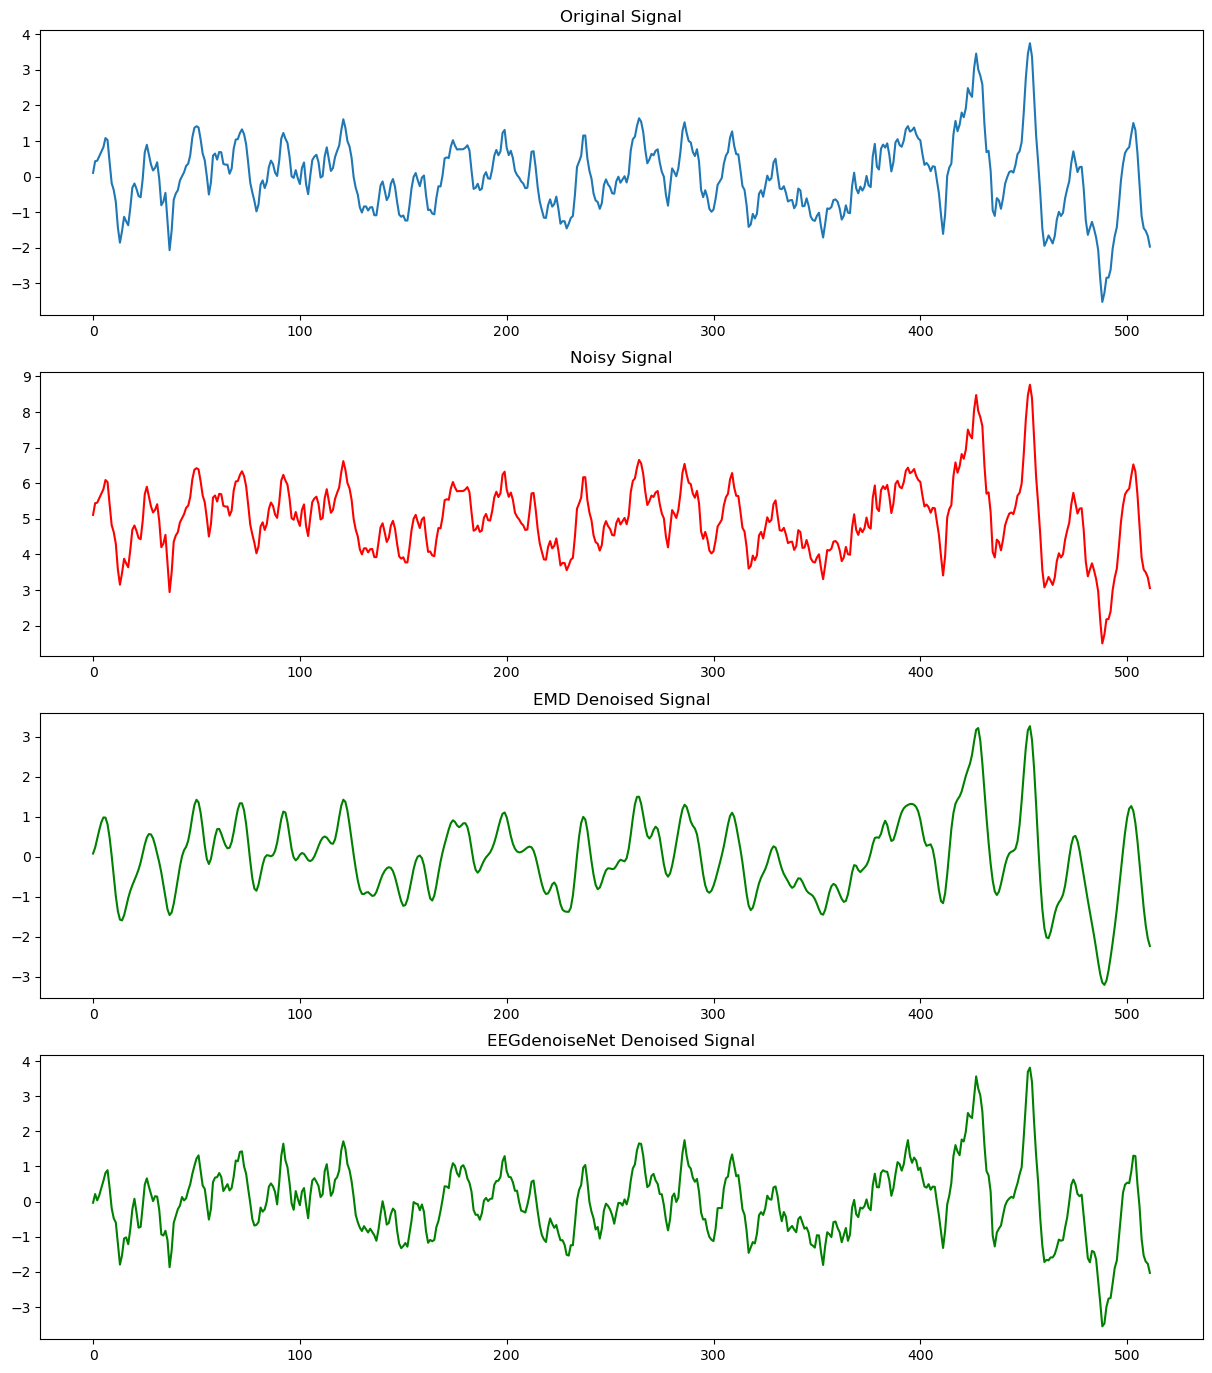

In [98]:
f, ax = plt.subplots(4, 1, figsize = (15, 17))
ax[0].plot(data['test']['ground_truth'][0]), ax[0].title.set_text("Original Signal")
ax[1].plot(data['test']['noisy_input'][0], color = 'red'), ax[1].title.set_text("Noisy Signal")
ax[2].plot(denoised_signal, color = 'green'), ax[2].title.set_text("EMD Denoised Signal")
ax[3].plot(data['test']['denoised'][0], color = 'green'), ax[3].title.set_text("EEGdenoiseNet Denoised Signal")
plt.show()

In [70]:
print(f"Correlation Coefficient (CC) for the example above: {cc(denoised_signal, data['test']['ground_truth'][0]):.2f}")

Correlation Coefficient (CC) for the example above: 0.98


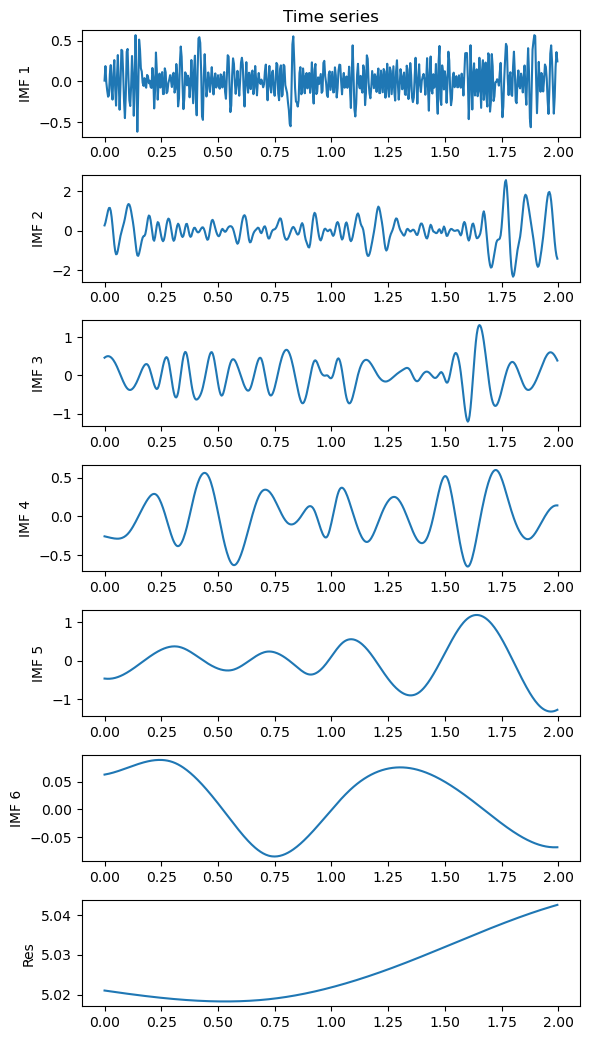

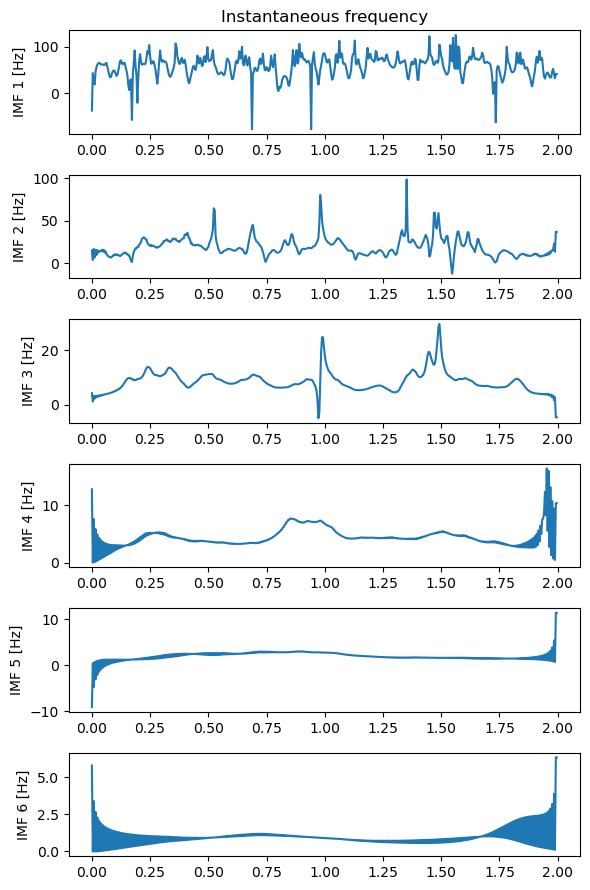

In [6]:
from PyEMD import Visualisation

# Visualization of the Extracted Components...
vis = Visualisation()
vis.plot_imfs(imfs = imfs, residue = res, t = t, include_residue = True)
vis.plot_instant_freq(t, imfs = imfs)
vis.show()

## 2. Denoising All Samples

In [71]:
data = load_data('data/tDCS/') # Can either be tDCS/tRNS/tACS/EOG/EMG

Finished Loading EEG Data!


In [72]:
from PyEMD import EMD
from statsmodels.tsa.stattools import acf
from scipy.stats import entropy 

def emd_denoise(signal, num_sec = 2, sampling_rate = 256):
    # Load the noisy signal
    t = np.arange(start = 0, stop = num_sec, step = 1/sampling_rate)    
    # Decompose signal into N-IMFs (Intrinsic Mode Functions)
    emd = EMD()
    emd.emd(signal)
    imfs, res = emd.get_imfs_and_residue()
    # Compute ACFs for the original signal and the IMFs
    acf_x, acfs_phi = acf(signal), [acf(imf) for imf in imfs]
    # Compute Mutual Information Scores + Normalize
    MI_scores = [entropy(acfs_phi[i][:2]) - entropy(acfs_phi[i][:2], acf_x[:2]) for i in range(len(acfs_phi))]
    normalized_MI = [score / max(MI_scores) for score in MI_scores]
    threshold = 0 # Set to 0 for cases without additive noise
    # Check for additive noise
    if (max(normalized_MI) - min(normalized_MI)) < 0.8:
        # Determine Threshold
        threshold = 0.5 * (normalized_MI[2] - normalized_MI[0]) + normalized_MI[0]
    # Reconstruct the denoised signal
    denoised_signal = np.zeros(signal.shape[0])
    for index in range(len(imfs)):
        if normalized_MI[index] > threshold: denoised_signal = denoised_signal + imfs[index]
    return denoised_signal

In [73]:
print('Applying EMD Denoising to Test Set...')
metrics = {k:[] for k in ['rrmse_temporal', 'rrmse_spectral', 'cc']}
for signal in tqdm(range(data['test']['noisy_input'].shape[0])):
    ground_truth, noisy_input = data['test']['ground_truth'][signal], data['test']['noisy_input'][signal]
    denoised_signal = emd_denoise(noisy_input)
    metrics['rrmse_temporal'].append(rrmse_temporal(denoised_signal, ground_truth))
    metrics['rrmse_spectral'].append(rrmse_spectral(denoised_signal, ground_truth))
    metrics['cc'].append(cc(denoised_signal, ground_truth))
print('Finished Denoising Process!')
avg_metrics = {k: np.mean(v) for k,v in metrics.items()}
print('Average Metrics:', avg_metrics)

Applying EMD Denoising to Test Set...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4510/4510 [01:44<00:00, 43.09it/s]

Finished Denoising Process!
Average Metrics: {'rrmse_temporal': 0.31314773498559273, 'rrmse_spectral': 0.13798712406376665, 'cc': 0.952246169420887}


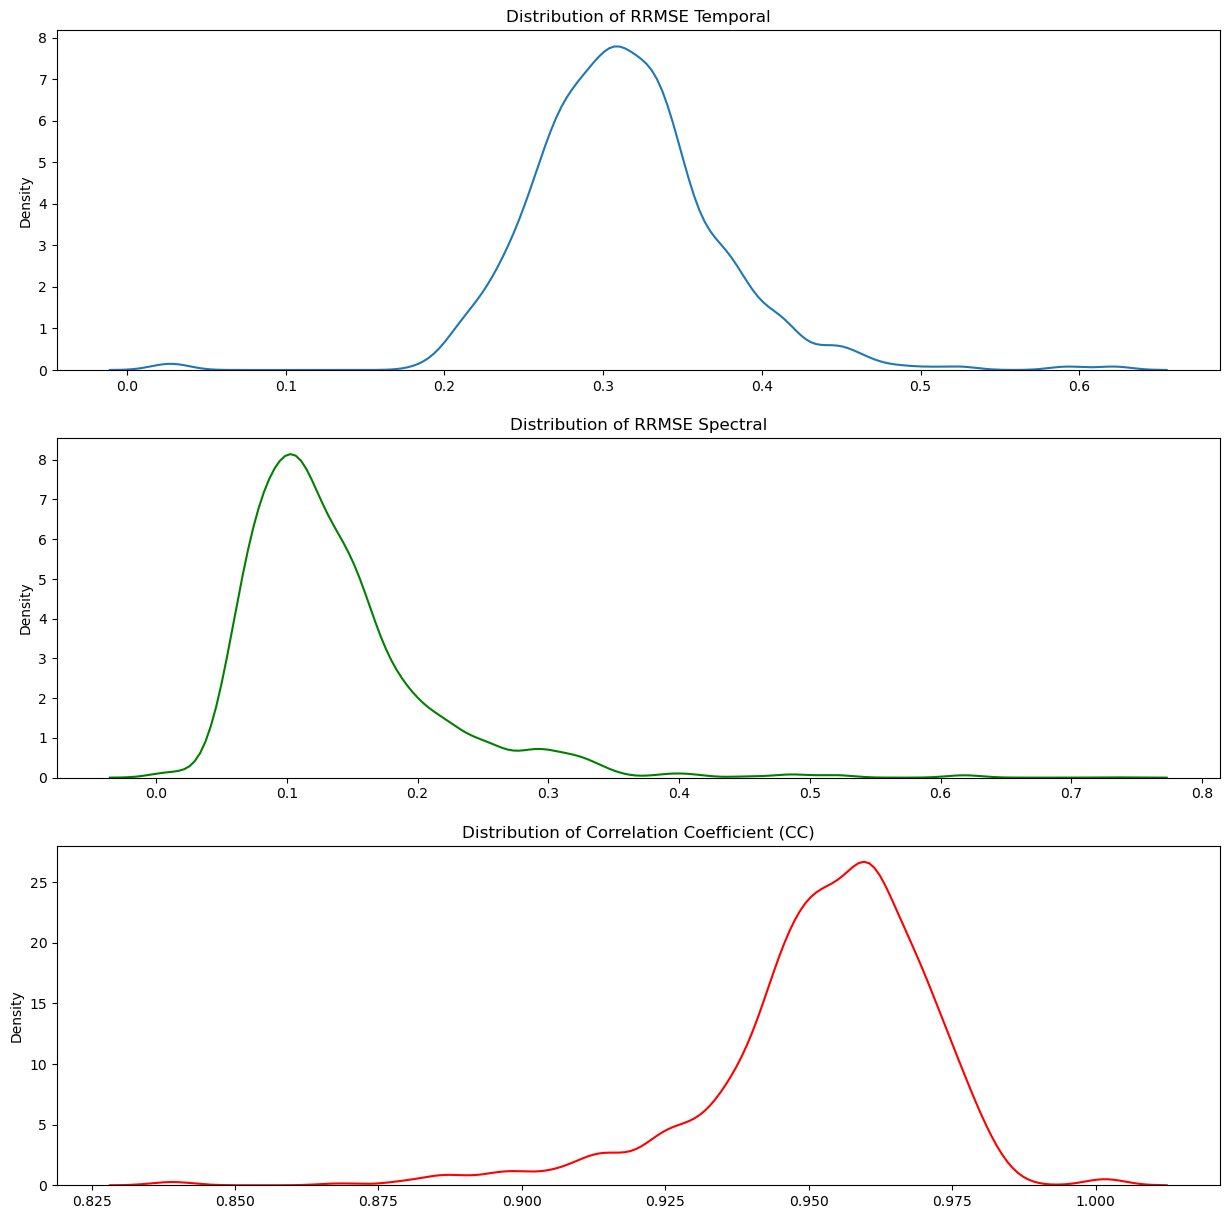

In [27]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

f, ax = plt.subplots(3, 1, figsize = (15, 15))
sns.kdeplot(metrics['rrmse_temporal'], ax = ax[0]), ax[0].title.set_text("Distribution of RRMSE Temporal")
sns.kdeplot(metrics['rrmse_spectral'], ax = ax[1], color = 'green'), ax[1].title.set_text("Distribution of RRMSE Spectral")
sns.kdeplot(metrics['cc'], ax = ax[2], color = 'red'), ax[2].title.set_text("Distribution of Correlation Coefficient (CC)")
plt.show()